# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Binary Approach

## Preprocessing

Packages:

In [59]:
import implicit
#import h5py
import pandas as pd
import numpy as np
# from implicit.evaluation import train_test_split
# from implicit.nearest_neighbours import (
#     normalize,
#     bm25_weight
# )
import scipy
from scipy.sparse import csr_matrix
import scipy.sparse
# from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import precision_at_k,mean_average_precision_at_k, ndcg_at_k
from random import shuffle
import itertools
import copy
from matplotlib import pyplot as plt


Import data:

In [60]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 
df.head(5)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem


DataFrame that assigns a category to every skill:

In [61]:
data_categories = df[["skill","category"]].drop_duplicates()
data_categories.head(5)

,skill,category
0,Windows NT/2000/XP,Betriebssystem
1,MAC OS X,Betriebssystem
2,Windows 7,Betriebssystem
3,Windows 8,Betriebssystem
4,iOS,Betriebssystem


In [62]:
data_categories[data_categories.category=="Umgebungen"]

,skill,category
19,NetBeans,Umgebungen
20,IntelliJ(Idea),Umgebungen
77,Visual Studio,Umgebungen
155,PhpStorm,Umgebungen
175,Workbench,Umgebungen
204,Pimcore,Umgebungen
237,JBuilder,Umgebungen
238,Ultra Edit,Umgebungen
239,Oracle Forms,Umgebungen
484,SharpDevelop,Umgebungen


Declaring various aiding variables

In [63]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]

In [64]:
skills_to_category = pd.read_csv("data/mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Data cleaning: <br> <br>
In order to evaluate the effect of inputmatrices  (APPENDIX XY) with a different level of sparsity, it is reasonable to introduce a function, that allows us to drop rare skills, that occur less than x times in the dataset. Sparsity is here defined as the relationship of ones and zeros inside a user-item-matrix, where ones represent, that a user is proficient in a certain skill. On the other hand a zero inside a user-item-matrix represents that a user has no knowledge about cetrain skill. Accordingly rare skills are responsible for many zeros inside the user-item-matrix. By dropping these rare skills the total amount of zeros is reduced and therefore the matrix becomes less sparse.

In [65]:
def get_rare_skills(data:pd.DataFrame, n:int):
    '''
    Function to determine all skills which occur less than n times in a given dataset.
    Dataset must be a pandas Dataframe with columns: person, skill.
    ----------
    Parameters: 
    data : pd.DataFrame
    The data in which rare skills are to be determined. 
    n : int 
    The threshold frequency.
    ----------
    Returns: 
    List of skills occuring less than n times in dataset.
    '''
    skill_frequency = {}
    for skill in data["skill"].unique():
        skill_frequency[skill] = data[data["skill"] == skill]["person"].nunique()

    return [s for s,f in skill_frequency.items() if f <= n]


***for insights in why no skills are dropped please refer to Appendix I***

In [66]:
rare_skills = get_rare_skills(df,0)
df = df[~df["skill"].isin(rare_skills)]


In [67]:
df.shape

(24586, 3)

The implicit library works with sparse-matrices. In order to transform a dataset into its sparse representation the dataset must be restructured in the following way: <br>
* Each row represents a user
* Each column represents a item/skill
* Each entity represents whether a user is proficient in a skill or not

In [68]:
df.head(5)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem


In [69]:
# Create a user-item matrix
df["count"] = 1
data_skills = df.pivot_table('count', index='person', columns="skill").fillna(0).astype(int).reset_index(drop=True)
#Set the index name = "userid"
data_skills.index.names = ["userids"]
data_skills

skill,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
userids,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now the matrix can be transformed into its sparse representation

In [70]:
data_skills_csr = scipy.sparse.csr_matrix(data_skills.values)
type(data_skills_csr)

scipy.sparse._csr.csr_matrix

Normalizing the data:

In the following a function will be introduced that performs different normalization techniques on the dataset. The idea behind **row normalization** in its simples form (here: implicit.nearest_neighbours.normalizeI) is, that a certain skill is more valuable for a user with a small skill set than for a user with a very large skill set. The following toy example will demonstrate this effect:
* Lets assume, that we want to investigate how important the skill "Python" is for user A and user B.
* The skill set of user A includes 10 different skills.
* The skill set of user B includes 100 different skills
* In our unnormalized dataset the importance of Python would be represented by a 1 for both users - no matter how large their skill set is. Hence the importance for both users is equal.
* However on the normalized dataset importance of "Python" would be larger for user A than for user B, because of the different size of their skillset.

While normalization only respects a single skill set at once in its calculation, the techniques **TF-IDF** and **bm25** techniques expand the idea of measureing skill importance by considering all skill sets in their computation. <br>

***For more detailed insights in these techniques please have a look at our documentation.*** 


In [71]:
bm25_grid  = {
            'K1': [2]#,20,50,100
            ,'B': [0.75] # 0.4,0.8,1
            }

# param_grid_bm25  = {'K1': [2,50,100], #2,20,50,100
#                     'B': [ 0.4,0.8,1] # 0.4,0.8,1
#                     }

In [72]:
def normalizer (data:csr_matrix ,param_grid:dict):
    '''
    Function to perform different normalization techniques on a user-item-matrix, where the users are represented in the rows and the items in the columns.
    The following techniques will be performed:
    - Raw (no normalization technique)
    - Normalization
    - tfidf
    - bm25
    ----------
    Parameters: 
    data : csr_matrix
    The data in sparse csr format which will be normalized. 
    param_grid : dict 
    A dictonary that holds different values for the parameters of implicit's bm25_weight.
    The dictonary must consist of the following key value pairs:
    - K1 : list of floats
    - B : list of floats
    ----------
    Returns: 
    - List holding the transformed dataset.
    - Pandas DataFrame, where each row provides information about the performed transformation. 
      The first row provides information about the first element in the returned list, the second row about the second element in the returned list and so on. 
    '''
    data_representations = ['Raw','Normalized', 'tfidf', 'bm25']    
    df_list = []
    data_list = []


    for representation in data_representations:
        df = pd.DataFrame(columns = ['data_representations', 'K1', 'B'])

        if representation == 'bm25':
            keys, values = zip(*param_grid.items())
            for c,v in enumerate(itertools.product(*values)):
                params = dict(zip(keys, v))
                
                #############
                # Initiate df for the parameter combination
                #############
                df = pd.DataFrame()
                df = pd.DataFrame(params, index =  [c])
                df["data_representations"] = [representation]
                df_list.append(df)

                #############
                # Add key value pair to the dictonary and initiate the bm25_weight function for every parameter combination
                #############
                params['X'] = data
                data_transf = implicit.nearest_neighbours.bm25_weight(**params)
                data_list.append(data_transf)
        else:

            match representation:
                case 'Normalized':
                    data_transf = implicit.nearest_neighbours.normalize(data)
                case 'tfidf':
                    data_transf = implicit.nearest_neighbours.tfidf_weight(data)
                case 'Raw':
                    data_transf = data
            df["data_representations"] = [representation]
            df["K1"] = np.nan
            df["B"] = np.nan  
            df_list.append(df)
            data_list.append(data_transf)

    return data_list, pd.concat(df_list).reset_index().drop(columns = ['index'])

In [73]:
data, df_rep = normalizer(data_skills_csr, bm25_grid)
df_rep

,data_representations,K1,B
0,Raw,NaN,NaN
1,Normalized,NaN,NaN
2,tfidf,NaN,NaN
3,bm25,2.0,0.75


## Implicit Library - Model Selection

In this section different recommender systems will be compared to each other. The comparison will be organized through a gridsearch. Conventionally a gridsearch is processed in combination with a cross validation.The goal of the gridsearch is to find the best possible parametrization (within the grid) for the model. The goal of the cross-validation is to reduce the impact of randomness on the model evaluation, which occurs when the data is splitted into train and test data. <br>

Since the algorithms of the implicit library perform different matrix factorization methods, the data can not be splitted into k-subsets during the cross-validation. A traditional KFold cross-validation is impractical for models, that use matrix factorization, because they need to decompose the whole dataset at once in order to make recommendations for every user and item within the dataset. The model could not make recommendations for users, if they are excluded in the traingsdata. <br>

Therefore a different cross-validation scheme will be introduced to reduce the effect of randomness on the model results. The cross-validation in our setup is organized by performing the **train.test-split of the implicit** library 5 times with a different random state on each iteration. This train-test-split does not exclude users from the trainingsdata. Instead the split is performed on user-item-interactions. Hence the traingsdata still includes every user and every item, but not every user-item-interaction. Metaphorically speaking the train-test-split replaces interaction (e.g. ones) with zeros. The replaced interactions are retained in the testdata. The model is evaluated on how well it can replicate the retrained user-item-interactions.

In [74]:
NUM_TRIALS = 5

In [75]:
def gridsearch_cv_implicit(data:csr_matrix, algorithm, param_grid: dict, k:int):
    '''
    This function will call the "normalizer" function in order to produce different transformations of the inserted user-item-matrix. 
    For more details about the transformationprocess check the documentation of the "normalizer" function.
    For each version of the user-item-matrix a gridsearch and a cross validation will be executed.
    This function uses the train-test-split of the implicit library to perform the cross validation.
    This train-test-split does not exclude whole users from the training set,but user-item-interactions. 
    The model is evaluated on how well it predicts the user-item-interactions that were excluded from the training set. 
    ----------
    Parameters: 
    data : csr_matrix
    The data in sparse csr format which will be normalized. 
    algorithm : 
    A algorithm from the implicit library.
    param_grid : dict 
    A dictonary that holds different values for the parameters of the algorithm.
    k : int
    The number of recommendations that will be made for each user in order to evaluate the model.
    ----------
    Returns: 
    - Pandas DataFrame that contains the results for each parametrization of the algorithm.
    '''
    df_result = pd.DataFrame()
    
    datasets, results = normalizer(data, bm25_grid)

    
    for i,data_rep in enumerate(datasets):
        row = results.loc[i].to_frame().T

        #############
        # Create tuples of my gird
        # E.g. keys = ('factors','alpha') ; values = ([10,20],[1])
        #############
        keys, values = zip(*param_grid.items())
        for val in itertools.product(*values):

            #############
            # This loop produces every possible combination of the hyperparameters as a dictonary
            #############
            params = dict(zip(keys, val))
            this_model = copy.deepcopy(algorithm)
            df_params = pd.DataFrame(params, index =  [i])
    

            for hyper_p,hyper_v  in params.items():
                #############
                # This loop unpacks the diconary by each parameter and initiates the model for each hpyerparameter of the corresponding dictonary
                #############
                setattr(this_model, hyper_p, hyper_v)

            ############
            # lists to store the results after each train_test_split under different random seed (c.p)
            ############
            p_train_test_results = np.zeros(NUM_TRIALS)
            map_train_test_results = np.zeros(NUM_TRIALS)
            ndcg_train_test_results = np.zeros(NUM_TRIALS)


            for seed in range(NUM_TRIALS):
                #############
                # Initiate the train_test_split
                #############
                train_mat, test_mat = implicit.evaluation.train_test_split(data_rep, train_percentage =  0.8, random_state = seed)
                this_model.fit(train_mat,show_progress=False)

                #############
                # measure evaluation metrixs for each possible hyperparameter combination
                #############
                p_at_k =  precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k ,show_progress=False)
                map_at_k = mean_average_precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k,show_progress=False)
                #var_ndcg_at_k = ndcg_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k,show_progress=False)


                #############
                # To list
                #############
                p_train_test_results[seed] = p_at_k
                map_train_test_results[seed] = map_at_k 
                #ndcg_train_test_results[seed] = var_ndcg_at_k

            #############
            # Create columns to store the scores for each hyperparameter combination after 5 different train_test_splits
            #############
            df_params["precision_at_k"] = np.mean(p_train_test_results)
            df_params["map_at_k"]  = np.mean(map_train_test_results)
            #df_params["ndcg_at_k"] = np.mean(ndcg_train_test_results)

            df_result = pd.concat([df_result,pd.concat([row,df_params],axis = 1)],axis = 0,ignore_index=True)

    return  df_result

### Alternating Least Squares

Define the parameter-grid

In [76]:
als_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30], 
              'alpha': [1] 
              }  
# als_grid = {
            #   'factors': [1,2],
            #   'regularization': [0.005],
            #   'iterations' : [15], 
            #   'alpha': [1] 
            #   }          

Initiate the Alternating Least Squares algorithm from the implicit library

In [77]:
# model = implicit.als.AlternatingLeastSquares(random_state= 42)
# results_als = gridsearch_cv_implicit(data_skills_csr, model, als_grid, k = 5)
# results_als

In [78]:
# results_als.to_csv("results_als.csv")
results_als = pd.read_csv("results_als.csv")
results_als.iloc[results_als.precision_at_k.idxmax()]

Unnamed: 0                    40
data_representations         Raw
K1                           NaN
B                            NaN
factors                        9
regularization              0.01
iterations                    15
alpha                          1
precision_at_k          0.571333
map_at_k                0.462859
ndcg_at_k                0.56003
Name: 40, dtype: object

Extracting the parametrization of the model with the best precision at k score

In [79]:
best_model_als = results_als.iloc[results_als.map_at_k.idxmax()]
best_model_als

Unnamed: 0                    27
data_representations         Raw
K1                           NaN
B                            NaN
factors                        8
regularization             0.005
iterations                    10
alpha                          1
precision_at_k          0.571195
map_at_k                 0.46472
ndcg_at_k               0.560624
Name: 27, dtype: object

### Logistic Matrix Factorization


Define the parameter-grid

In [80]:
lmf_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30], 
              'alpha': [1] 
}


Initiate the Logistic Matrix Factorization algorithm from the implicit library

In [81]:
# model = implicit.lmf.LogisticMatrixFactorization(random_state= 42)
# results_lmf= gridsearch_cv_implicit(data_skills_csr, algorithm = model,param_grid =  lmf_grid, k = 5)
# results_lmf

In [82]:
#results_lmf.to_csv('results_lmf.csv')
results_lmf = pd.read_csv('results_lmf.csv', index_col = 0)
results_lmf

,data_representations,K1,B,factors,regularization,iterations,alpha,precision_at_k,map_at_k,ndcg_at_k
0,Raw,NaN,NaN,3,0.005,10,1,0.296645,0.199434,0.284637
1,Raw,NaN,NaN,3,0.005,15,1,0.317075,0.214490,0.303739
2,Raw,NaN,NaN,3,0.005,30,1,0.310359,0.209155,0.297752
3,Raw,NaN,NaN,3,0.010,10,1,0.301123,0.205383,0.291394
4,Raw,NaN,NaN,3,0.010,15,1,0.318851,0.213527,0.303988
...,...,...,...,...,...,...,...,...,...,...
562,bm25,120.0,1.0,15,0.010,15,1,0.191443,0.105793,0.179151
563,bm25,120.0,1.0,15,0.010,30,1,0.172647,0.097386,0.163505
564,bm25,120.0,1.0,15,0.020,10,1,0.178262,0.099788,0.169277
565,bm25,120.0,1.0,15,0.020,15,1,0.188320,0.101774,0.173134


Extracting the parametrization of the model with the best precision at k score

In [83]:
best_model_lmf = results_lmf.iloc[results_lmf.map_at_k.idxmax()]
best_model_lmf

data_representations    Normalized
K1                             NaN
B                              NaN
factors                          7
regularization                0.02
iterations                      15
alpha                            1
precision_at_k            0.342807
map_at_k                  0.236807
ndcg_at_k                 0.333338
Name: 88, dtype: object

### Bayesian Personalized Ranking

Define the parameter-grid

In [84]:
bpr_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30], 
}

Initiate the Logisitic Matrix Factorization algorithm from the implicit library

In [85]:
# model = implicit.bpr.BayesianPersonalizedRanking(random_state= 42)
# results_bpr= gridsearch_cv_implicit(data_skills_csr, algorithm = model,param_grid =  bpr_grid, k = 5)
# results_bpr

In [86]:
# results_bpr.to_csv('results_bpr.csv')
results_bpr = pd.read_csv('results_bpr.csv', index_col = 0)
results_bpr

,data_representations,K1,B,factors,regularization,iterations,precision_at_k,map_at_k,ndcg_at_k
0,Raw,NaN,NaN,3,0.005,10,0.474473,0.368146,0.460840
1,Raw,NaN,NaN,3,0.005,15,0.466369,0.358393,0.452068
2,Raw,NaN,NaN,3,0.005,30,0.426161,0.321278,0.419129
3,Raw,NaN,NaN,3,0.010,10,0.475401,0.368810,0.461495
4,Raw,NaN,NaN,3,0.010,15,0.467553,0.359157,0.452836
...,...,...,...,...,...,...,...,...,...
562,bm25,120.0,1.0,15,0.010,15,0.493787,0.388139,0.483068
563,bm25,120.0,1.0,15,0.010,30,0.483000,0.375649,0.478297
564,bm25,120.0,1.0,15,0.020,10,0.471583,0.368724,0.460327
565,bm25,120.0,1.0,15,0.020,15,0.485652,0.381570,0.475572


Extracting the parametrization of the model with the best precision at k score

In [87]:
best_model_bpr = results_bpr.iloc[results_bpr.map_at_k.idxmax()]
best_model_bpr

data_representations        bm25
K1                          50.0
B                            1.0
factors                       15
regularization             0.005
iterations                    15
precision_at_k          0.499554
map_at_k                0.393646
ndcg_at_k               0.489411
Name: 307, dtype: object

### Comparison of the best models across the algorithms

This section will identify the best model over all algortihms, which were used.
Therefore two dictonaries are created.

The dictonary "comparision_dict" is used to compare the results of the best performing models of each algorithm.

The dictonary "best_dict" is then used to determine the best model across all different algortihms.

In [88]:
comparison_dict= {
            'model': ['als','lmf','bpr']
            ,'data_representation': [best_model_als.data_representations, best_model_lmf.data_representations, best_model_bpr.data_representations]
            ,'factors': [best_model_als.factors, best_model_lmf.factors, best_model_bpr.factors]
            ,'regularization': [best_model_als.regularization, best_model_lmf.regularization, best_model_bpr.regularization]    
            ,'map_at_k': [best_model_als.map_at_k, best_model_lmf.map_at_k, best_model_bpr.map_at_k]
            ,'precision_at_k': [best_model_als.precision_at_k, best_model_lmf.precision_at_k, best_model_bpr.precision_at_k]
            }
            
best_dict = {
            'als':best_model_als
            ,'lmf':best_model_lmf
            ,'bpr':best_model_bpr
            }



best_model_comparison = pd.DataFrame(comparison_dict)
best_model_comparison

,model,data_representation,factors,regularization,map_at_k,precision_at_k
0,als,Raw,8,0.005,0.464720,0.571195
1,lmf,Normalized,7,0.020,0.236807,0.342807
2,bpr,bm25,15,0.005,0.393646,0.499554


In [89]:
best_key = best_model_comparison.iloc[best_model_comparison.map_at_k.idxmax()]["model"]
best_model = best_dict[best_key]
best_model

Unnamed: 0                    27
data_representations         Raw
K1                           NaN
B                            NaN
factors                        8
regularization             0.005
iterations                    10
alpha                          1
precision_at_k          0.571195
map_at_k                 0.46472
ndcg_at_k               0.560624
Name: 27, dtype: object

### Initiate a best data transformation:

Get the transformation technique, that lead to the best results(raw, normalized, tf-idf or bm25)

In [90]:
best_grid_bm25  = { 'X': data_skills_csr,
                    'K1': best_model["K1"], 
                    'B': best_model["B"] 
                    }

In [91]:
data_representation_dict  = {'Raw':data_skills_csr
                            ,'Normalized':  implicit.nearest_neighbours.normalize(data_skills_csr)
                            , 'tfidf':implicit.nearest_neighbours.tfidf_weight(data_skills_csr)
                            , 'bm25':implicit.nearest_neighbours.bm25_weight(**best_grid_bm25)
                            }    

In [92]:
best_data = data_representation_dict[best_model["data_representations"]]
best_data = best_data.tocsr()

In [93]:
train_mat, test_mat = implicit.evaluation.train_test_split(best_data, train_percentage =  0.8, random_state = 42)

In [94]:
print("Full matrix shape:",best_data.shape ,"; Train matrix shape: ", train_mat.shape, "; Test matrix shape: ", test_mat.shape)

Full matrix shape: (404, 734) ; Train matrix shape:  (404, 734) ; Test matrix shape:  (404, 734)


### Initiate the best model

In [95]:
def initiate_best_model(key:str , model_params:pd.Series, data:csr_matrix):
    '''
    This function initiates a model based on the algorithm, that is represented by the parameter 'key'.
    The model will be initiated with the given parameters and will be fitted on the given data. 
    ----------
    Parameters: 
    key: str 
    A string that determines which algorithm will be used.
    model_params : pd.Series 
    A pandas Series holding the parameters for the algorithm.
    data : csr_matrix
    The trainingsdata to fit the model on. 
    ----------
    Returns: 
    - A fitted model of the implicit library, that is initiated with and fitted on the given data. This model can be used to recommend skills to users.
    '''
    if key == 'als':
        model = implicit.als.AlternatingLeastSquares(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"],  random_state= 42) #,alpha= model_params["alpha"]
    elif key == 'lmf':
        model = implicit.lmf.LogisticMatrixFactorization(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"], random_state= 42)#,alpha= model_params["alpha"]
    elif key == 'bpr':
        model = implicit.bpr.BayesianPersonalizedRanking(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"], random_state= 42)
    model.fit(data, show_progress= False)
    return model

In [96]:
model = initiate_best_model(best_key, best_model, train_mat)

## Evaluation

Comparing the model to the baseline of most often occuring skills:

In [97]:
def baseline_precision_at_k(k):
    '''
    This function calculates the precision at k for the baseline model.
    ----------
    Parameters: 
    k: int 
    The number of recommended skills per user.
    ----------
    Returns: 
    - The precision at k for the baseline model.
    '''
    #########
    # Get the most common skills
    #########
    most_common_skills = data_skills.sum(axis=0).nlargest(k)	


    #########
    # Create a list to store the precision at k for each user
    #########
    p_at_5_baseline_list  = np.zeros(len(PERSONS))
    for i in range(0,len(PERSONS)):
        
        #########
        # Get all user-item-interactions for a user within the test set
        #########
        user_series = pd.DataFrame.sparse.from_spmatrix(test_mat, columns=data_skills.columns).loc[i]
        
        #########
        # Get all user-item-interactions > 0 for a user
        #########
        user_known_skills = user_series[user_series > 0]

        #########
        # Check if the most common skills are in the user's known skills
        #########
        user_known_skills_vs_most_common = user_known_skills.index.isin(most_common_skills.index)

        #########
        # Calculate the precision at k
        #########
        matches = user_known_skills_vs_most_common.sum()
        p_at_5_baseline_list[i] = matches/k
    return p_at_5_baseline_list.mean()


Precision at k = 5 of the baseline:

In [98]:
baseline_precision_at_k(5)

0.149009900990099

Precision at k = 5 of our model:

In [99]:
implicit.evaluation.precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=5,show_progress=False)

0.5614344503233392

Precision at k = 10 of the baseline:

In [100]:
baseline_precision_at_k(10)

0.13044554455445545

Precision at k = 10 of our model

In [101]:
implicit.evaluation.precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=10,show_progress=False)

0.529625951671632

**Comparison between our model and the baseline:** 

The model predicts way more user-item-interactions, that were retained in the testdata, correct than the baseline. 
Therefore the model has to recognizes individual skill sets to a certain level. Otherwise it would not make better recommendations than the baseline. <br>

## Recommendations

### Get Recommendations for a known user

Create a dictonary that holds the id of a skill as key and the name of a skill as value. <br>
This function is necassary to exclude certain skills from the recommendations later on.

In [102]:
# Id and skills
dict_skills_id = {}
for c,skill in enumerate(data_skills.columns):
        dict_skills_id[c] = skill

In [103]:
def get_key_from_value(dictonary: dict, values:list):
    '''
    This function returns the key of a dictionary, that is associated with the given value. 
    ----------
    Parameters: 
    dict_skills_id: dict 
    A dictionary with skills as keys and ids as values.
    values : str 
    A string that is associated with a key in the dictionary.
    ----------
    Returns: 
    - A list holding the keys to the corresponding values.
    '''
    output = [k for k,v in dictonary.items() for val in values if v == val]
    return output

In [104]:
def get_recommendations (model,userids:list, mat:csr_matrix ,eval_mat:csr_matrix = None ,items_to_exclude:list = None ,n:int = 5):
    '''
    This function produces recommendations for known user. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    userids : list
    A list that holds the userids for which recommendations will be generated. 
    train_mat : csr_matrix
    A user-item matrix that holds the known items for the given users.
    test_mat : csr_matrix
    Optional: A user-item matrix that holds user-item interactions and can be used for evaluation.
    items_to_exclude : list
    Optional: A list that holds the items that should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for the given users.
    '''
    output = pd.DataFrame()
    if items_to_exclude is not None:
        items_to_exclude  = get_key_from_value(dict_skills_id,items_to_exclude)

    for u in userids:
        
        
        #############
        # Do recommendations for every user in the list. The known items are in the matrix the model was trained on
        #############

        skill_ids, scores  = model.recommend(u, user_items= mat[u], N = n , filter_already_liked_items=True, filter_items = items_to_exclude)
        recommendations_df = pd.DataFrame({"skill": [dict_skills_id[skill] for skill in skill_ids], "score": scores})

        #############
        # Get all known skills for each user by indexing the full data matrix
        #############
        
        if eval_mat is not None:
            eval_data = pd.DataFrame.sparse.from_spmatrix(data = eval_mat.tocsr()[u],columns=data_skills.columns).T.reset_index().rename(columns = {"index": "skill",0: "rating"}).sort_values(by = "rating", ascending = False)
   
            #############
            # Merge both df in order to see, if the recommended skills are the skills, which the user already knows, but were left out in the trainings data
            #############
            recommendations_df = recommendations_df.merge(eval_data, on = ["skill"], how = "left").rename(columns = {"rating": "rating_in_test_data"})


        #############
        # Merge the category information to the recommendations
        #############
        recommendations_df = recommendations_df.merge(data_categories, on = "skill", how = "left")
        recommendations_df["user_id"]  = u
        recommendations_df = recommendations_df.set_index("user_id")
        output = pd.concat([output, recommendations_df])
    
    return output

In [105]:
userid= [0]
get_recommendations(model, userid, train_mat,test_mat,  n = 5)


,skill,score,rating_in_test_data,category
user_id,,,,
0,REST,0.885694,1,Standards
0,SCRUM,0.812002,1,Projektmanagement / Vorgehensmodelle
0,Unit Tests (Komponententests),0.803812,1,Methoden und Praktiken
0,MySQL,0.704764,1,Datenbank
0,Windows 7,0.662781,1,Betriebssystem


In [106]:
occurence = np.zeros(len(PERSONS))
for i,p in enumerate(PERSONS):
    main_cat = df[df["person"] == p]["category"].value_counts().index[0]
    recommended_cat = get_recommendations(model, [i], train_mat, items_to_exclude = ["SCRUM"], n = 10)["skill"].apply(lambda x : category_dict[x]).to_numpy()
    count = 0
    for cat in recommended_cat:
        if cat == main_cat:
            count += 1
    occurence[i] = count

In [107]:
occurence.shape

(404,)

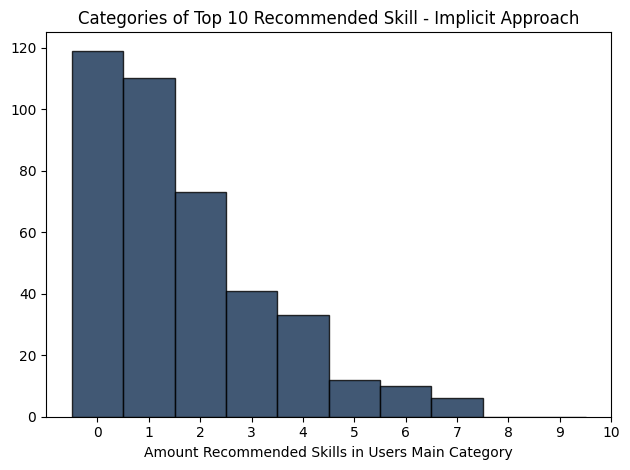

In [108]:
plt.hist(occurence,color="#112e51",alpha=0.8,edgecolor='k',align="left", bins=range(11))
plt.title("Categories of Top 10 Recommended Skill - Implicit Approach")
plt.xlabel("Amount Recommended Skills in Users Main Category")
plt.xticks(np.arange(0,11,1))
plt.tight_layout()
plt.savefig("categories_of_top_10_recommended_skill_binary.png",dpi=300)

### Get recommendations for a new user

Initiate a new user 

In [109]:
new_id = 404
new_skills = {
                "Englisch":1,
                "Python":1,
                "MySQL":1,
                "MongoDB":1,
                "vs code":1,
                "Docker":1,
                "GIT":1,
                "GitHub":1
            }

In [110]:
def get_recommendations_new_user(model, userid:int, user_skills:dict, old_user_mat:csr_matrix, items_to_exclude:list = None ,n:int = 5):
    '''
    This function produces recommendations for a new user. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    userid : int
    The id of the new user. 
    user_skills : dict
    A dictonary contain.
    old_user_mat : csr_matrix
    Optional: A user-item matrix on which the model was trained on.
    items_to_exclude : list
    Optional: A list that holds the items that should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for a new users.
    '''
    if items_to_exclude is not None:
        items_to_exclude  = get_key_from_value(dict_skills_id,items_to_exclude)
    #############
    # Create a new user as dataframe, where a row represents a user and the columns represent the skills of that user
    #############
    new_user = pd.DataFrame(user_skills, index = [userid])


    #############
    # Append the new user to the old user matrix and fill the missing values with 0
    #############
    mat = pd.concat([old_user_mat,new_user]).sort_index().fillna(0).astype(int)
    mat = scipy.sparse.csr_matrix(mat.values)

    #############
    # Transform the matrix which contains the new user according to the results of the grid search
    #############
    best_grid_bm25  = { 'X': mat, 'K1': best_model["K1"], 'B': best_model["B"] }
    
    data_representation_dict  = {
                                'Raw':mat
                                ,'Normalized':  implicit.nearest_neighbours.normalize(mat)
                                ,'tfidf':implicit.nearest_neighbours.tfidf_weight(mat)
                                ,'bm25':implicit.nearest_neighbours.bm25_weight(**best_grid_bm25)
                                }   
 
    mat = data_representation_dict[best_model["data_representations"]]
    mat = mat.tocsr()

    #############
    # Do recommendations for the new user
    #############

    skill_ids, scores  = model.recommend(userid, user_items= mat[userid], N = n , filter_already_liked_items=True, filter_items = items_to_exclude, recalculate_user=True)
    recommendations_df = pd.DataFrame({"skill": [dict_skills_id[skill] for skill in skill_ids], "score": scores})

    #############
    # Merge the category information to the recommendations
    #############
    recommendations_df = recommendations_df.merge(data_categories, on = "skill", how = "left")
    recommendations_df["user_id"]  = userid
    recommendations_df = recommendations_df.set_index("user_id")
 
    return recommendations_df

In [112]:
get_recommendations_new_user(model,new_id, new_skills, data_skills,items_to_exclude = ["SCRUM"], n = 5)

,skill,score,category
user_id,,,
404,JavaScript,0.153167,Programmiersprachen / Scriptsprachen
404,Java,0.152045,Programmiersprachen / Scriptsprachen
404,SQL,0.142827,Datenbank
404,Gitlab,0.140781,"CI/CD, Build- und Versionskontrollsysteme"
404,JIRA,0.136556,Issue Management


## Conclusion

## Appendix I - Effect of Dropping Rare Skills on Recommender Precision

By dropping skills we can investigate the tradeoff between a matrix with a higher level of density and the removal of distinguishing features.

Rare skills serve as distinguishing feature for users, because they will have assigned a value after tf-idf or bm25 transformation. 

***for more details about tf-idf and bm25 please have a look at our documentation***  

***HIER MUSS ICH NOCH MEIN GRID DURCHLAUFEN LASSEN DAMIT ICH MEINE BESTEN PARAMETER WEI=***

Infos best model:

In [48]:
best_model

Unnamed: 0                    40
data_representations         Raw
K1                           NaN
B                            NaN
factors                        9
regularization              0.01
iterations                    15
alpha                          1
precision_at_k          0.571333
map_at_k                0.462859
ndcg_at_k                0.56003
Name: 40, dtype: object

In [49]:
def measure_performance_for_n(min_support:list):
    '''
    This function measures the performance of a recommender system across matrices with a different level of sparsity. 
    ----------
    Parameters: 
    min_support : list
    A list of integers that represent the minimum absolute support threshold. Items/ skills with a lower absolute support will be removed from the dataset.
    ----------
    Returns: 
    - A pandas DataFrame that demonstrates the effect of the sparsity on the performance of the recommender system (c.p.).
    '''
    output = pd.DataFrame()
    for n in min_support:
        #############
        # Import the data
        #############
        df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 

        #############
        # trim dataset according to min absolute support of skills and insert ratings afterwards
        #############
        rare_skills = get_rare_skills(df,n)
        df = df[~df["skill"].isin(rare_skills)]
        unique_skills = df["skill"].nunique()

        #############
        # Create a user-item matrix
        #############
        df["count"] = 1
        matrix = df.pivot_table('count', index='person', columns="skill").fillna(0).astype(int).reset_index(drop=True)
        matrix.index.names = ["userids"]
        matrix_csr = scipy.sparse.csr_matrix(matrix.values)
        
        #############
        # Measure sparsity (ratio between non-zero and zero value entries) of the trainset
        #############
        number_of_elements_in_matrix = matrix_csr.shape[0] * matrix_csr.shape[1]
        number_of_nonzeros_in_matrix = matrix_csr.sum()

        sparsity = 1 - number_of_nonzeros_in_matrix/number_of_elements_in_matrix
        sparsity = round(sparsity,4)
        #############
        # Split the data into train and test set
        #############
        train_mat, test_mat = implicit.evaluation.train_test_split(matrix_csr, train_percentage =  0.8, random_state = 42)



        #############
        # Initialize the model
        #############
        model = initiate_best_model(best_key, best_model, train_mat)

        
        prec_at_k = precision_at_k(model, train_mat, test_mat, K = 5, show_progress = False)
        map_at_k = mean_average_precision_at_k(model, train_mat, test_mat, K = 5, show_progress = False)
        var_ndcg_at_k = ndcg_at_k(model, train_mat, test_mat, K = 5, show_progress = False)
        result = pd.DataFrame({
                                "unique_skills":unique_skills
                                ,"sparsity": sparsity
                                ,"precision_at_k": prec_at_k
                                ,"map_at_k": map_at_k
                                ,"ndcg_at_k": var_ndcg_at_k
                                }, index = [n])

        result.index.names = ["min_support"] 
        output = pd.concat([output,result])


    return output

Minimum absolute support:

In [50]:
min_absolute_support = [0, 1, 2, 5, 10, 20]

In [51]:
measure_performance_for_n(min_absolute_support)

,unique_skills,sparsity,precision_at_k,map_at_k,ndcg_at_k
min_support,,,,,
0,734,0.9185,0.557907,0.447865,0.542808
1,665,0.9101,0.600120,0.489343,0.581912
2,614,0.9028,0.576651,0.471844,0.567836
5,510,0.8849,0.565657,0.455219,0.554607
10,392,0.8558,0.574808,0.465579,0.564256
20,270,0.8052,0.603214,0.484912,0.579966


**Conclusion regarding the effect of dropping rare skills:** <br>
We can observe, that lowering the sparsity of a matrix does not necessarily lead to a higher precision at k score. 
Nevertheless it can still increase the precision at k slightly, but the tradeoff is not worth it, because a majority of all available skills will not be part of the models recommendations anymore. 

## Appendix II -  Reverse Problem for User Recommendations on Items

Transpose the user-item-matrix in order to get a item-user matrix and use the transformation technique on it, that achieved the best results:

In [52]:
data_best_u = implicit.nearest_neighbours.bm25_weight(data_skills_csr.T, K1 = 100, B = 0.8)
data_best_u = data_best_u.tocsr()
data_best_u

<734x404 sparse matrix of type '<class 'numpy.float64'>'
	with 24156 stored elements in Compressed Sparse Row format>

train-test-split:

In [53]:
train_mat_u, test_mat_u = implicit.evaluation.train_test_split(data_best_u, train_percentage =  0.8, random_state = 42)

fit the model:

In [54]:
model_best_u = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01, iterations = 15,random_state = 42)# alpha = 1, 
model_best_u.fit(train_mat_u)

100%|██████████| 15/15 [00:00<00:00, 27.49it/s]


In [55]:
def get_recommendations_reversed (model,skillids:list, mat:csr_matrix ,eval_mat:csr_matrix = None ,items_to_exclude:list = None ,n:int = 5):
    '''
    This function recommends,which users are most likely qualified to learn a certain skill. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    skillids : list
    A list that holds the skill ids for which recommendations will be generated. 
    mat : csr_matrix
    A item-user matrix that holds the known users for the given skill.
    eval_mat : csr_matrix
    Optional: A item-user matrix that holds item-user interactions and can be used for evaluation.
    items_to_exclude : list
    Optional: A list that holds the users, who should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for the given skill.
    '''
    output = pd.DataFrame()

    
    #skillids  = get_key_from_value(dict_skills_id,skillids)
    #skillids = [s[0] for s in skillids]
    for value in skillids:
        key  = get_key_from_value(dict_skills_id,[value])
        key = key[0]
        #############
        # Do recommendations for every user in the list. The known items are in the matrix the model was trained on
        #############

        user_ids, scores  = model.recommend(key, user_items= mat[key], N = n , filter_already_liked_items=True, filter_items = items_to_exclude)
        recommendations_df = pd.DataFrame({"user_id": user_ids, "score": scores})

        #############
        # Get all known skills for each user by indexing the full data matrix
        #############
        
        if eval_mat is not None:
            eval_data = pd.DataFrame.sparse.from_spmatrix(data = eval_mat.tocsr()[s],columns=data_skills.columns).T.reset_index().rename(columns = {"index": "user_id",0: "rating"}).sort_values(by = "rating", ascending = False)
   
            #############
            # Merge both df in order to see, if the recommended skills are the skills, which the user already knows, but were left out in the trainings data
            #############
            recommendations_df = recommendations_df.merge(eval_data, on = ["user_id"], how = "left").rename(columns = {"rating": "rating_in_test_data"})



        recommendations_df["skill_id"]  = value
        recommendations_df = recommendations_df.set_index("skill_id")
        output = pd.concat([output, recommendations_df])
        
    return output

In [56]:
get_recommendations_reversed(model_best_u, ["Python","Java"],train_mat_u)

,user_id,score
skill_id,,
Python,270,0.713534
Python,12,0.673033
Python,309,0.659310
Python,392,0.614753
Python,47,0.506845
Java,239,0.869117
Java,316,0.688858
Java,241,0.676700
Java,353,0.638023


## Appendix III - Similarities

### Simularities

### Items

In [57]:
get_key_from_value(dict_skills_id,[".NET Framework"])

[2]

In [58]:
dict_skills_id

{0: '.NET Compact Framework',
 1: '.NET Core',
 2: '.NET Framework',
 3: '3D-Modellierung',
 4: 'ABAP',
 5: 'ADO.NET',
 6: 'AIX',
 7: 'ARIS',
 8: 'ARIS ITArchitect',
 9: 'AS400',
 10: 'ASP Generalist',
 11: 'ASP.NET',
 12: 'ASP.NET MVC-Framework',
 13: 'ASP.NET WebAPI',
 14: 'AWS',
 15: 'AWS Lambda',
 16: 'Abstract',
 17: 'Access',
 18: 'Accessibility / WCAG',
 19: 'Active Directory',
 20: 'ActiveX',
 21: 'Adobe CC',
 22: 'Adobe Flash',
 23: 'Adobe Illustrator',
 24: 'Adobe InDesign',
 25: 'Adobe Photoshop',
 26: 'Adobe Premiere',
 27: 'Adobe XD',
 28: 'After Effects',
 29: 'Agile Methoden',
 30: 'Ajax',
 31: 'Alexa-Skills',
 32: 'Alpine',
 33: 'Analytics',
 34: 'Android',
 35: 'Android Studio',
 36: 'Anforderungsanalyse',
 37: 'Anforderungsmanagement',
 38: 'Angular (2 und höher)',
 39: 'Angular Generalist',
 40: 'Angular Material',
 41: 'Angular Theming',
 42: 'AngularJS',
 43: 'Animations (transition, @keyframes)',
 44: 'Ansible',
 45: 'Ant',
 46: 'Apache',
 47: 'Apache Derby',
 48:

In [72]:
def get_similar_items(skill:str, n:int = 5):
    skillid = get_key_from_value(dict_skills_id,[skill])[0]
    skill_id, sim = model.similar_items(skillid, N=n)
    # display the results using pandas for nicer formatting
    similarity_df  = pd.DataFrame({"skill": data_skills.columns[skill_id], "score": sim})
    similarity_df = similarity_df.merge(data_categories, how = "left", left_on = "skill", right_on = "skill")
    return similarity_df

In [78]:
get_similar_items("SQL") 

,skill,score,category
0,SQL,1.000000,Datenbank
1,REST,0.865508,Standards
2,JSON,0.850959,Webentwicklung
3,Test Driven Development (TDD),0.839007,Methoden und Praktiken
4,Continuous Integration (CI),0.820422,Methoden und Praktiken


### Users

In [432]:
new_skills = {
                "Windows 11":1,
                "Englisch":1,
                "Chinesisch (Mandarin)":1,
                "Python":1,
                "MATLAB":1,
                "Java":1,
                "MySQL":1,
                "SQLBase":1,
                "Microsoft SQL Server":1,
                "Google Cloud Platform":1,
                "MongoDB":1,
                "JSON":1,
                "Docker":1,
                "Statische Codeanalyse": 1,
                "Power BI":1,
                "Postman":1,
                "PowerShell":1,
                "Github actions":1
            }

In [433]:
new_user_id_list = list(new_skills.keys())

In [435]:
user_ids_, sim = model.similar_users(0, N=10)
# display the results using pandas for nicer formatting
similarity_df  = pd.DataFrame({"user_ids": data_skills.index[user_ids_], "score": sim})
similarity_df

,user_ids,score
0,273,1.0
1,247,1.0
2,62,1.0
3,9,1.0
4,8,1.0
5,7,1.0
6,6,1.0
7,5,1.0
8,4,1.0
9,3,1.0


# ALT

In [ ]:
def gridsearch_cv_implicit(data, algorithm, param_grid):
    df_list = []
    df_result = pd.DataFrame()

    data_list, df = normalizer(data, param_grid_bm25)

    
    for b,d in enumerate(data_list):
        df1 = df.loc[b].to_frame().T
        data_rep = d

        keys, values = zip(*param_grid.items())
        for v in itertools.product(*values):
            
            #############
            # This for loop produces every possible combination of the hyperparameters within a dictonary
            #############
            params = dict(zip(keys, v))
            this_model = copy.deepcopy(algorithm)
            df2 = pd.DataFrame()
            df2 = pd.DataFrame(params, index =  [b])
    
            

            for k, v in params.items():
                #############
                # This loop unpacks the diconary by each parameter and initiates the model for each hpyerparameter of the corresponding dictonary
                #############
                setattr(this_model, k, v)

            ############
            # lists to store the results after each train_test_split under different random seed (c.p)
            ############
            p_train_test_results = []
            map_train_test_results = []
            ndcg_train_test_results = []


            for r_seed in range(0,5):
                #############
                # Initiate the train_test_split
                #############
                train_mat, test_mat = implicit.evaluation.train_test_split(data_rep, train_percentage =  0.8, random_state = r_seed)
                this_model.fit(train_mat,show_progress=False)

                #############
                # measure evaluation metrixs for each possible hyperparameter combination
                #############
                p_at_k =  precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=5 ,show_progress=False)
                map_at_k = mean_average_precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=5,show_progress=False)
                var_ndcg_at_k = ndcg_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=5,show_progress=False)


                #############
                # To list
                #############
                p_train_test_results.append(p_at_k)
                map_train_test_results.append(map_at_k)
                ndcg_train_test_results.append(var_ndcg_at_k)

            #############
            # Create columns to store the scores for each hyperparameter combination after 5 different train_test_splits
            #############
            df2["precision_at_k"] = np.mean(p_train_test_results)
            df2["map_at_k"]  = np.mean(map_train_test_results)
            df2["ndcg_at_k"] = np.mean(ndcg_train_test_results)

            df_result = df1.merge(df2, left_index=True, right_index=True)
            df_list.append(df_result)
    
    return pd.concat(df_list).reset_index().drop(columns = ['index'])

In [ ]:
userid= [0,1]

def get_recommendations (userids, user_items_mat_train,full_data_mat ,items_to_exclude = None ,n = 5):
    df_list = []

    if items_to_exclude is not None:
        items_to_exclude  = get_key_from_value(dict_skills_id,items_to_exclude)

    for u in userids:
        
        
        #############
        # Do recommendations for every user in the list. The known items are in the matrix the model was trained on
        #############
        skill_ids, scores  = model.recommend(u, user_items= user_items_mat_train[u], N = n , filter_already_liked_items=True, filter_items = items_to_exclude)
        recommendations_df = pd.DataFrame({ "skill": SKILLS, "score": scores, "already_liked": np.in1d(skill_ids, user_items_mat_train.tocsr()[u].indices)})
        recommendations_df["user_id"] = [u] * len(recommendations_df)
        recommendations_df = recommendations_df.rename(columns = {"already_liked": "already_liked_in_train"})

        #############
        # Get all known skills for each user by indexing the full data matrix
        #############
        data_best_user_id = pd.DataFrame.sparse.from_spmatrix(data = full_data_mat.tocsr()[u],columns=data_skills.columns).T.reset_index().rename(columns = {"index": "skill",0: "rating"}).sort_values(by = "rating", ascending = False)
        data_best_user_id["user_id"] = [u] * len(data_best_user_id)
      
        #############
        # Merge both df in order to see, if the recommended skills are the skills, which the user already knows, but were left out in the trainings data
        #############
        recommendations_df = recommendations_df.merge(data_best_user_id, on = ["skill","user_id"], how = "left").rename(columns = {"rating": "rating_in_original"})
        

        #############
        # Merge the category information to the recommendations
        #############
        recommendations_df = recommendations_df.merge(data_categories, on = "skill", how = "left")
        recommendations_df.set_index("user_id", inplace = True)
        df_list.append(recommendations_df)
    return pd.concat(df_list)

In [ ]:
recommendations_df = get_recommendations(userid, train_mat,best_data,n = 10,item_to_exclude= ["MySQL"])
recommendations_df

,skill,score,already_liked_in_train,rating_in_original,category
user_id,,,,,
0,SCRUM,0.691310,False,1,Projektmanagement / Vorgehensmodelle
0,Unit Tests (Komponententests),0.664733,False,1,Methoden und Praktiken
0,XML/XSL,0.624774,False,0,Standards
0,CSS,0.605857,False,0,Webentwicklung
0,CSS,0.605857,False,0,Programmiersprachen / Scriptsprachen
0,REST,0.578240,False,1,Standards
0,Dokumentation,0.567920,False,0,Einsatzfelder / Erfahrungen / Schwerpunkte
0,jQuery,0.562962,False,0,Webentwicklung
0,Dependency Injection,0.553882,False,1,Methoden und Praktiken


In [ ]:
results_als= gridsearch_cv_implicit(data_skills_csr, algorithm = implicit.als.AlternatingLeastSquares(random_state = 42),param_grid =  als_grid)
results_als

,data_representations,K1,B,factors,regularization,iterations,alpha,precision_at_k,map_at_k,ndcg_at_k
0,Raw,NaN,NaN,1,0.005,15,1,0.459071,0.357035,0.444635
1,Raw,NaN,NaN,2,0.005,15,1,0.488633,0.385132,0.472573
2,Normalized,NaN,NaN,1,0.005,15,1,0.455082,0.351404,0.438058
3,Normalized,NaN,NaN,2,0.005,15,1,0.450738,0.350056,0.436405
4,tfidf,NaN,NaN,1,0.005,15,1,0.325121,0.230505,0.306353
5,tfidf,NaN,NaN,2,0.005,15,1,0.378964,0.273204,0.358962
6,bm25,3.0,0.6,1,0.005,15,1,0.092194,0.044148,0.079159
7,bm25,3.0,0.6,2,0.005,15,1,0.195050,0.122778,0.187092


In [ ]:
skill_ids, scores  = model.recommend(0, user_items= train_mat[0], N = 5 , filter_already_liked_items=True, recalculate_user=True)
recommendations_df = pd.DataFrame({ "skill": matrix.columns[skill_ids], "score": scores, "already_liked": np.in1d(skill_ids, train_mat.tocsr()[0].indices)})
recommendations_df = recommendations_df.rename(columns = {"already_liked": "already_liked_in_train"})
recommendations_df

,skill,score,already_liked_in_train
0,SCRUM,0.892121,False
1,Unit Tests (Komponententests),0.774384,False
2,MySQL,0.772703,False
3,Dependency Injection,0.659050,False
4,REST,0.650433,False
